In [14]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
import copy
from joblib import Parallel, delayed

from functools import reduce
import pickle
from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta
from sklearn.metrics import mean_absolute_error

# import mlb
import statistics as st
import lightgbm as lgbm
from scipy.stats import norm


In [15]:
# sys.path.append('../../')
# import src.utils as utils

In [16]:
OFFSET = 45
MAX_LAG = 27
LAGS = list(range(OFFSET, MAX_LAG + OFFSET))

In [17]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
UPDATE_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting-update'

BASE_DIR = MAIN_DATA_DIR
TRAIN_DIR = MAIN_DATA_DIR / 'train'

In [18]:
players = pd.read_csv(BASE_DIR / 'players.csv')
seasons = pd.read_csv(BASE_DIR / 'seasons.csv')


rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
standings = pd.read_csv(TRAIN_DIR / 'standings_train.csv')
awards = pd.read_csv(TRAIN_DIR / 'awards_train.csv')


In [19]:
players = pd.read_csv(BASE_DIR / 'players.csv')

In [20]:
def flatten(df, col):
    du = (df.pivot(index='playerId', columns='EvalDate', 
               values=col).add_prefix(f'{col}_').
      rename_axis(None, axis=1).reset_index())
    return du


def reducer(left, right):
    return left.merge(right, on='playerId')


def make_train_lag(df, lags):
    df['EvalDate'] = pd.to_datetime(df['date'], format="%Y%m%d")
    for lag in tqdm(lags):
        dp = df[['playerId','EvalDate'] + ['target1', 'target2', 'target3', 'target4']].copy()
        dp['EvalDate']  =dp['EvalDate'] + timedelta(days=lag) 
        df = df.merge(dp, on=['playerId', 'EvalDate'], suffixes=['',f'_{lag}'], how='left')
        gc.collect()
    df = df.sort_values(by=['playerId', 'EvalDate'])
    df = df.dropna()
    return df

def make_test_lag(sub, last):
    sub['playerId'] = sub['date_playerId'].apply(lambda s: int(  s.split('_')[1]  ) )
    assert sub.date.nunique() == 1
    dte = sub['date'].unique()[0]
    
    eval_dt = pd.to_datetime(dte, format='%Y%m%d')
    dtes = [eval_dt + timedelta(days = -k) for k in LAGS]
    mp_dtes = {eval_dt + timedelta(days = -k): k for k in LAGS}
    
    sl = last.loc[last['EvalDate'].between(dtes[-1], dtes[0]), ['EvalDate','playerId'] + ['target1', 'target2', 'target3', 'target4']].copy()
    sl['EvalDate'] = sl['EvalDate'].map(mp_dtes)
    du = [flatten(sl, col) for col in ['target1', 'target2', 'target3', 'target4']]
    du = reduce(reducer, du)
    return du, eval_dt

In [21]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [65]:
class Rt4kaidoTest:
    def __init__(self, train_features_dicts, models_notgameday, models_gameday, weights, usetimelinefeature=False):
        
        self.usetimelinefeature = usetimelinefeature
        self.train_features_dicts = train_features_dicts
        self.feature_cols1 = train_features_dicts[0]['feature_cols1']
        self.feature_cols2 = train_features_dicts[0]['feature_cols2']
        self.feature_cols3 = train_features_dicts[0]['feature_cols3']
        self.feature_cols4 = train_features_dicts[0]['feature_cols4']
        self.models_notgameday = models_notgameday
        self.models_gameday = models_gameday
        self.weights = weights


        self.test_players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'mlbDebutDate', 'DebutAge', 'heightInches', 'weight']
        self.test_rosters_cols = ['date', 'playerId', 'teamId', 'status']
        self.test_standings_cols = ['date','teamId', 'wildCardRank', 'sportGamesBack']
        self.test_scores_cols = ['date','playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
               'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
               'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
               'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
               'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
               'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
               'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
               'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
               'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
               'groundOutsPitching', 'runsPitching', 'doublesPitching',
               'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
               'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
               'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
               'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
               'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
               'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
               'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
               'inheritedRunnersScored', 'catchersInterferencePitching',
               'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
               'assists', 'putOuts', 'errors', 'chances', 'gamePk']
        

    def test_oneline(self, test_df, sample_prediction_df):
        
        null = np.nan
        true = True
        false = False
        
        sample_prediction_df = sample_prediction_df.reset_index(drop=True)
        test_date = test_df.index[0]

        sample_prediction_df[['target1', 'target2', 'target3', 'target4']] = 0
        model_num = len(self.models_notgameday)
        
        for i in range(model_num):
            
            self.train_features_dict = self.train_features_dicts[i]
            
            # creat dataset
            date_and_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
            sample_prediction_df['playerId'] = date_and_playerId[1].astype(int)
            sample_prediction_df['date'] = test_date

            # Dealing with missing values
            if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
                test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
            else:
                test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
                for col in self.train_features_dict['rosters_cols_all']:
                    if col == 'playerId': continue
                    test_rosters[col] = np.nan
            test_rosters['date'] = test_date

            if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
                test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
                test_scores = test_scores.groupby('playerId').sum().reset_index()
            else:
                test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
                for col in self.train_features_dict['scores_cols_all']:
                    if col == 'playerId': continue
                    test_scores[col] = np.nan
            test_scores['date'] = test_date

            if test_df['awards'].iloc[0] == test_df['awards'].iloc[0]:
                test_awards = pd.DataFrame(eval(test_df['awards'].iloc[0]))
                test_awards = test_awards.groupby('playerId').sum().reset_index()
            else:
                test_awards = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
                for col in self.train_features_dict['awards_cols_all']:
                    if col == 'playerId': continue
                    test_awards[col] = np.nan
            test_awards['date'] = test_date


            test = sample_prediction_df[['playerId', 'date']].copy()
            test = test.merge(self.train_features_dict['players'][self.test_players_cols], on='playerId', how='left')
            test = test.merge(test_rosters[self.test_rosters_cols], on=['playerId', 'date'], how='left')
            test = test.merge(test_scores[self.test_scores_cols], on=['playerId', 'date'], how='left')
            test = test.merge(test_awards, on=['playerId', 'date'], how='left')
            test = test.merge(self.train_features_dict['player_target_stats'], how='left', left_on=["playerId"],right_on=["playerId"])

            if test_df['standings'].iloc[0] == test_df['standings'].iloc[0]:
                test_standings = pd.DataFrame(eval(test_df['standings'].iloc[0]))
            else:
                test_standings = pd.DataFrame({'teamId': test['teamId'].unique()})
                for col in self.train_features_dict['standings_cols_all']:
                    if col == 'teamId': continue
                    test_standings[col] = np.nan   
            test_standings['date'] = test_date


            test = test.merge(test_standings[self.test_standings_cols], on=['teamId', 'date'], how='left')
            test = test.merge(self.train_features_dict['team_target_stats'], how='left', left_on=["teamId"],right_on=["playerId"], suffixes=('', 'team_'))
            test['wildCardRank'] = test['wildCardRank'].astype(float)


            test['label_playerId'] = test['playerId'].map(self.train_features_dict['player2num'])
            test['label_primaryPositionName'] = test['primaryPositionName'].map(self.train_features_dict['position2num'])
            test['label_teamId'] = test['teamId'].map(self.train_features_dict['teamid2num'])
            test['label_status'] = test['status'].map(self.train_features_dict['status2num'])
            test['label_birthCity'] = test['birthCity'].map(self.train_features_dict['birthCityn2num'])
            test['award_flag'] = test['awardSeason'].isna()*1
            test['mlbDebutDateflag'] = (test['mlbDebutDate'] == test['date']) * 1
            test['sincemlbDebutDateflag'] = (test['date'] >= test['mlbDebutDate']) * 1
            test['diffmlbDebutDateflag'] = (test['date'] - test['mlbDebutDate'])

            date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
            test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
            test['week_day'] = date_.weekday()
            test['month'] = date_.month


            ## season_info
            on_preseason_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['preSeasonStartDate', 'preSeasonEndDate']])
            on_season_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['regularSeasonStartDate', 'regularSeasonEndDate']]) * 2
            on_postseason_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['postSeasonStartDate', 'postSeasonEndDate']]) * 3

            special_days = self.train_features_dict['seasons']['lastDate1stHalf'].to_list() + self.train_features_dict['seasons']['allStarDate'].to_list() + self.train_features_dict['seasons']['firstDate2ndHalf'].to_list()
            special_idxes = 0
            for day in special_days:
                special_idxes += (test['date'] == day) * 4

            on_total_season_idxes = on_preseason_idxes
            on_total_season_idxes[on_season_idxes==2] = 2
            on_total_season_idxes[on_postseason_idxes==3] = 3
            on_total_season_idxes[special_idxes==4] = 4

            test['season_info'] = on_total_season_idxes


    #         test['season_info'] = 2

            if self.usetimelinefeature:

                test['gameday'] = ~test['battingOrder'].isna()*1
                test = pd.merge(test, self.train_features_dict['train_last_game'], on=['playerId'], how='left')
                test['daysSinceLastGame'] = (pd.to_datetime(test['date'], format="%Y%m%d") - pd.to_datetime(test['lastdate'], format="%Y%m%d")).dt.days
                test.loc[test['gameday']==1,'daysSinceLastGame']=0

                self.train_features_dict['train_last_game'] = pd.merge(self.train_features_dict['train_last_game'], test[test['gameday']==1][['playerId','date']], on=['playerId'], how='left')
                self.train_features_dict['train_last_game']['lastdate'].update(self.train_features_dict['train_last_game']['date'])
                self.train_features_dict['train_last_game'] = self.train_features_dict['train_last_game'][['playerId', 'lastdate']]

                test['rosterday'] = ~test['status'].isna()*1
                test = pd.merge(test, self.train_features_dict['train_last_roster'], on=['playerId'], how='left')
                test['daysSinceLastRoster'] = (pd.to_datetime(test['date'], format="%Y%m%d") - pd.to_datetime(test['lastroster'], format="%Y%m%d")).dt.days
                test.loc[test['rosterday']==1,'daysSinceLastRoster']=0

                self.train_features_dict['train_last_roster'] = pd.merge(self.train_features_dict['train_last_roster'], test[test['rosterday']==1][['playerId','date']], on=['playerId'], how='left')
                self.train_features_dict['train_last_roster']['lastroster'].update(self.train_features_dict['train_last_roster']['date'])
                self.train_features_dict['train_last_roster'] = self.train_features_dict['train_last_roster'][['playerId', 'lastroster']]

            
            test_gameday = test[test['gameday']==1]

            if len(test_gameday) != 0:
                gameday_index = list(test_gameday.index)

                test_X = test.iloc[gameday_index]


                pred1 = self.models_gameday[i][0][4].predict(test_X[self.feature_cols1])
                pred2 = self.models_gameday[i][1][4].predict(test_X[self.feature_cols2])
                pred3 = self.models_gameday[i][2][4].predict(test_X[self.feature_cols3])
                pred4 = self.models_gameday[i][3][4].predict(test_X[self.feature_cols4])

                # merge submission
                sample_prediction_df['target1'].iloc[gameday_index] += self.weights[i] * pred1
                sample_prediction_df['target2'].iloc[gameday_index] += self.weights[i] * pred2
                sample_prediction_df['target3'].iloc[gameday_index] += self.weights[i] * pred3
                sample_prediction_df['target4'].iloc[gameday_index] += self.weights[i] * pred4

            # ------------------------------------------------------------

            test_notgameday = test[test['gameday']==0]
            if len(test_notgameday) != 0:
                notgameday_index = list(test_notgameday.index)

                test_X = test.iloc[notgameday_index]

                pred1 = self.models_notgameday[i][0][4].predict(test_X[self.feature_cols1])
                pred2 = self.models_notgameday[i][1][4].predict(test_X[self.feature_cols2])
                pred3 = self.models_notgameday[i][2][4].predict(test_X[self.feature_cols3])
                pred4 = self.models_notgameday[i][3][4].predict(test_X[self.feature_cols4])

                # merge submission
                sample_prediction_df['target1'].iloc[notgameday_index] += self.weights[i] * pred1
                sample_prediction_df['target2'].iloc[notgameday_index] += self.weights[i] * pred2
                sample_prediction_df['target3'].iloc[notgameday_index] += self.weights[i] * pred3
                sample_prediction_df['target4'].iloc[notgameday_index] += self.weights[i] * pred4

            sample_prediction_df = sample_prediction_df.fillna(0.)
        
        sample_prediction_df['target1'] = np.clip(sample_prediction_df['target1'], 0, 100)
        sample_prediction_df['target2'] = np.clip(sample_prediction_df['target2'], 0, 100)
        sample_prediction_df['target3'] = np.clip(sample_prediction_df['target3'], 0, 100)
        sample_prediction_df['target4'] = np.clip(sample_prediction_df['target4'], 0, 100)

        del sample_prediction_df['playerId']
        del sample_prediction_df['date']
        
        return sample_prediction_df

## Inference

In [66]:
# 新しいtrain_update, players, nextDayPlayerEngagementの展開されたものを読み込める必要あり

class LocalTest:
    def __init__(self, start_day, end_day):
        self.start_day = start_day
        self.end_day = end_day
        
    def make_env(self):
    
        self.original_data = pd.read_csv(UPDATE_DATA_DIR / "train_updated.csv")
        self.original_data = self.original_data[(self.original_data['date'] >= self.start_day) & (self.original_data['date'] <= self.end_day)].reset_index(drop=True)
        
        test_players = pd.read_csv(UPDATE_DATA_DIR / 'players.csv')
        self.players_test = test_players[test_players['playerForTestSetAndFuturePreds']==True]['playerId'].unique()
        
        self.test_targets = pd.read_csv(UPDATE_DATA_DIR / 'train/nextDayPlayerEngagement_train.csv')
        self.test_targets = self.test_targets[(self.test_targets['date'] >= self.start_day) & (self.test_targets['date'] <= self.end_day) & (self.test_targets['playerId'].isin(self.players_test))].reset_index(drop=True)
        
        self.scores = []
        return self
        
    def iter_test(self):
        self.num = len(self.original_data['date'].unique())
        self.current = 0
        self.predict_flag = True
        
        return self
    
    def __iter__(self):
        return self

    def __next__(self):
        assert self.predict_flag == True, 'You must call `predict()` successfully before you can continue with `iter_test()`'
     
        if self.current == self.num:
            print(np.mean(self.scores))
            raise StopIteration()

        test_df = self.original_data.iloc[self.current:self.current+1].set_index('date')

        sample_prediction_df = pd.DataFrame()
        sample_prediction_df['date'] = [test_df.index[0]] * len(self.players_test)
        next_day = (pd.to_datetime(sample_prediction_df['date'], format="%Y%m%d") + timedelta(days=1)).astype(str).str.replace('-', '')
        # next_day.str.cat(players_test.astype(str))
        sample_prediction_df['date_playerId'] = [next_day[0] + '_' + str(p_) for p_ in self.players_test]
        sample_prediction_df['target1'] = 0
        sample_prediction_df['target2'] = 0
        sample_prediction_df['target3'] = 0
        sample_prediction_df['target4'] = 0

        sample_prediction_df = sample_prediction_df.set_index('date')

        self.current += 1
        self.predict_flag = False
        return test_df, sample_prediction_df
    
    def predict(self, sample_prediction_df):
        
        assert list(sample_prediction_df.columns) == ['date_playerId', 'target1', 'target2', 'target3', 'target4'], 'columns miss.'
        self.predict_flag = True
    
        sample_prediction_df = sample_prediction_df.reset_index()
        date_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
        sample_prediction_df['date'] = (pd.to_datetime(date_playerId[0], format="%Y%m%d") + timedelta(days=-1)).astype(str).str.replace('-', '').values.astype(int)
        sample_prediction_df['playerId'] = date_playerId[1].values.astype(int)
        target_oneday = pd.merge(sample_prediction_df, self.test_targets, how='left', on=['date', 'playerId'], suffixes=('', '_true'))
        score = mean_absolute_error(target_oneday.loc[:, 'target1':'target4'], target_oneday.loc[:, 'target1_true':'target4_true'])
        
        self.scores.append(score)


In [67]:
with open("../97/output/train_features_dict97.pickle", mode="rb") as f:
    train_features_dict94 = pickle.load(f)
with open('../99/output/models99.pickle', mode="rb") as f:
    models94 = pickle.load(f)
with open("../94/output/train_features_dict94.pickle", mode="rb") as f:
    train_features_dict95 = pickle.load(f)
with open('../94/output/models94.pickle', mode="rb") as f:
    models95 = pickle.load(f)
with open("../97/output/train_features_dict97.pickle", mode="rb") as f:
    train_features_dict97 = pickle.load(f)
with open('../98/output/models98.pickle', mode="rb") as f:
    models97 = pickle.load(f)
    
models = [models94, models95, models97]
train_features_dicts = [train_features_dict94, train_features_dict95, train_features_dict97]
weights = [0.33, 0.34, 0.33]
    
# with open('../94/output/models94_gameday.pickle', mode="rb") as f:
#     models_gameday = pickle.load(f)
    
## self.train_features_dict['train_last_roster']が更新されちゃうから，これは絶対呼ぶ
rt4kaido_test = Rt4kaidoTest(train_features_dicts, models, models, weights, usetimelinefeature=True)

In [68]:
mlb = LocalTest(20210601, 20210630)
env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

In [69]:
sample_prediction_dfs = []
for (test_df, sample_prediction_df) in tqdm(iter_test): # make predictions here
    
    sample_prediction_df = rt4kaido_test.test_oneline(test_df, sample_prediction_df)
    env.predict(sample_prediction_df)   
    
    test_date = test_df.index[0]
    date_and_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
    sample_prediction_df['playerId'] = date_and_playerId[1].astype(int)
    sample_prediction_df['date'] = test_date
    sample_prediction_dfs.append((sample_prediction_df))
    
#     if test_df['playerBoxScores'].iloc[0] != test_df['playerBoxScores'].iloc[0]:
#         print(test_df.index[0])

30it [00:22,  1.33it/s]

1.239238645236501


In [ ]:
5
94 1.232405021530883
97 1.31
94+97 1.2408740124228663
98 1.2488268983957596


6
97 1.291944741598578
95 1.2836792788028137
95+97 1.272542953954886
94 1.2438211396401588
94+97 1.246 0.8 0.2
94+98 1.24104803377294
98 1.2448648709195642
99 1.2435531775955764
94+99 1.2396874627220773
94+99+98 1.2388595842573313


7
97 0.9633148578489212
95 0.986589317625635
97+95 0.9628951688287534
94 0.93221601689386
94+95 0.9378938748293344
94+97 0.9312774123820835 0.8 0.2
98 0.9341658086489323
94+98 0.9297017281407554
99 0.9343159280203741
94+99 0.9292405990974855
94+98+99 0.9283181613525323

5月 1.2815181343261905
4月 1.2991224262632444


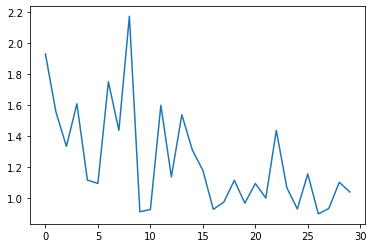

In [60]:
plt.plot(iter_test.scores)

In [111]:
targets = pd.read_csv(UPDATE_DATA_DIR / 'train/nextDayPlayerEngagement_train.csv')

In [112]:
# creat dataset
sample_prediction_dfs = pd.concat(sample_prediction_dfs)

In [113]:
sample_prediction_df_ = pd.merge(sample_prediction_dfs, targets, on=['playerId', 'date'], how='left')

,count,mean,std,min,25%,50%,75%,max
target2_x,35610.0,2.341815,3.393335,0.093765,0.473493,1.066962,2.804238,45.623064


,count,mean,std,min,25%,50%,75%,max
target2_y,35610.0,2.71142,6.809472,0.0,0.222284,0.709867,2.375454,100.0


1.8736368934059855

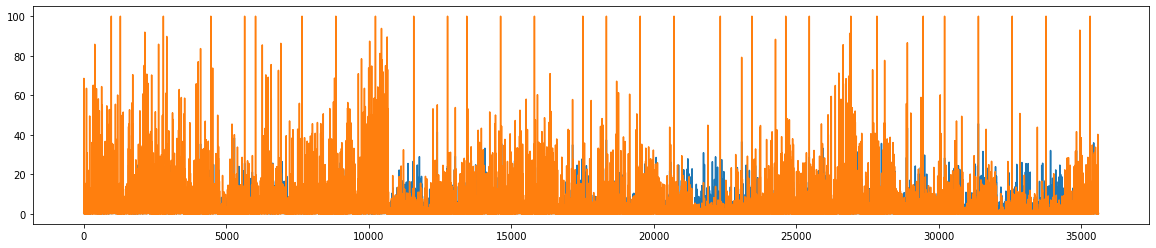

In [114]:
plt.figure(figsize=(20, 4))
plt.plot(sample_prediction_df_['target2_x'])
plt.plot(sample_prediction_df_['target2_y'])
display(pd.DataFrame(sample_prediction_df_['target2_x']).describe().T)
display(pd.DataFrame(sample_prediction_df_['target2_y']).describe().T)
mean_absolute_error(sample_prediction_df_['target2_y'], sample_prediction_df_['target2_x'])

In [115]:
print(mean_absolute_error(sample_prediction_df_[['target1_y', 'target2_y', 'target3_y', 'target4_y']], sample_prediction_df_[['target1_x', 'target2_x', 'target3_x', 'target4_x']]))
print(mean_absolute_error(sample_prediction_df_['target1_y'], sample_prediction_df_['target1_x']))
print(mean_absolute_error(sample_prediction_df_['target2_y'], sample_prediction_df_['target2_x']))
print(mean_absolute_error(sample_prediction_df_['target3_y'], sample_prediction_df_['target3_x']))
print(mean_absolute_error(sample_prediction_df_['target4_y'], sample_prediction_df_['target4_x']))

1.2633533193616748
0.9808042292747581
1.8736368934059855
0.8099894558606922
1.3889826989052643
